In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
# Verifica si tienes una GPU disponible y configura el dispositivo.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo actual:", device)

Dispositivo actual: cuda


In [3]:
# Cargar datos
df = pd.read_pickle('./Datasets/df_ETHUSDT_4h.pickle')
df.head()

,Date,Open,High,Low,Close,Volume,RSI,EMA20,EMA40,EMA60,fastk,fastd,macd_line,signal_line,upper,middle,lower
0,2020-10-18 13:00:00,375.66,376.85,374.81,375.74,41634.6019,57.566743,371.915841,371.948304,372.790333,100.000000,94.322544,-0.199425,-1.094532,378.707663,373.312,367.916337
1,2020-10-18 17:00:00,375.72,378.64,374.98,378.11,45734.8910,61.067141,372.505761,372.248875,372.964749,100.000000,100.000000,0.317210,-0.812184,378.879214,375.254,371.628786
2,2020-10-18 21:00:00,378.12,380.00,372.50,373.00,93611.4211,51.250433,372.552832,372.285515,372.965904,0.000000,66.666667,0.310730,-0.587601,379.026793,375.062,371.097207
3,2020-10-19 01:00:00,372.97,375.72,372.73,375.03,57683.7913,54.387353,372.788752,372.419392,373.033580,31.954903,43.984968,0.464050,-0.377271,378.785173,375.514,372.242827
4,2020-10-19 05:00:00,375.02,377.71,374.28,375.75,63807.0544,55.481546,373.070776,372.581861,373.122643,43.101133,25.018679,0.636320,-0.174553,378.800107,375.526,372.251893


In [4]:
df.columns[1::]

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'EMA20', 'EMA40',
       'EMA60', 'fastk', 'fastd', 'macd_line', 'signal_line', 'upper',
       'middle', 'lower'],
      dtype='object')

In [5]:
len(df.columns[1::])

16

***

CUDA

Epoch 0, loss: 0.26963356137275696
Epoch 100, loss: 0.0006998599856160581
Epoch 200, loss: 0.0003196610196027905
Epoch 300, loss: 0.0002825903065968305
Epoch 400, loss: 0.000260916945990175
Epoch 500, loss: 0.00024208208196796477
Epoch 600, loss: 0.00022185608395375311
Epoch 700, loss: 0.0001999337982852012
Epoch 800, loss: 0.0001826811785576865
Epoch 900, loss: 0.0001722250017337501


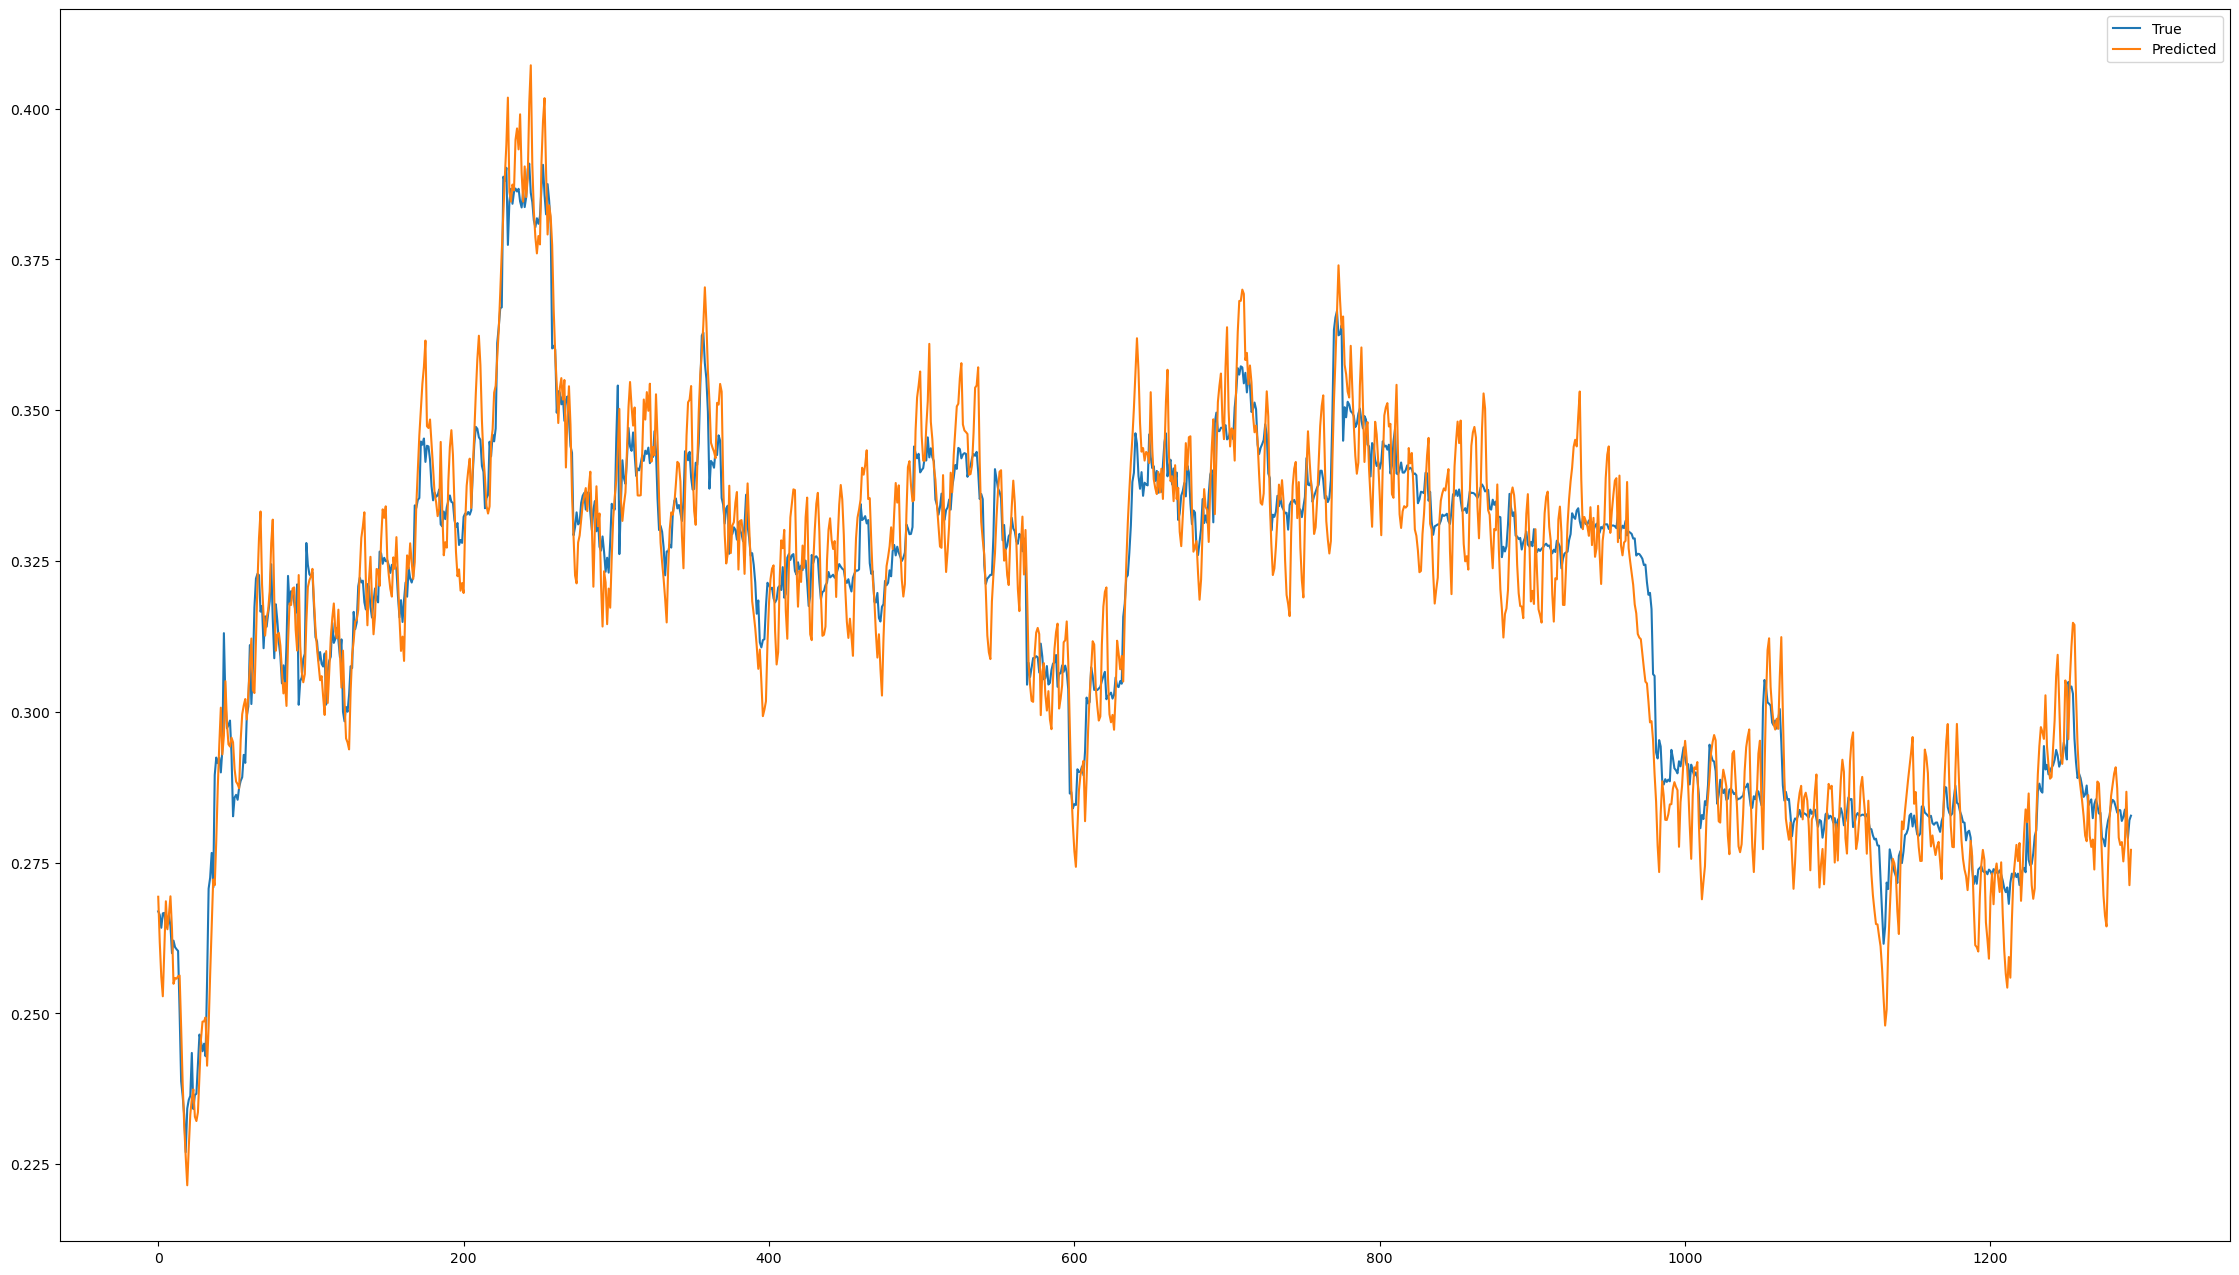

In [50]:
# Parámetros
seq_length = 10  # Longitud de la secuencia
train_size = 0.8  # Porcentaje de datos para entrenamiento
inputs = len(df.columns[1::])  # Número de características de entrada

# Función para preparar los datos
def prepare_data(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length, :]
        label = data[i+seq_length, 3]  # Se asume que la columna 3 es 'Close'
        sequences.append(seq)
        target.append(label)

    # Convertir las listas a numpy arrays y luego a tensores de PyTorch
    sequences = np.array(sequences)
    target = np.array(target)
    return torch.tensor(sequences, dtype=torch.float32).cuda(), torch.tensor(target, dtype=torch.float32).view(-1, 1).cuda()


loss_function = nn.MSELoss()

# Normalizar los datos
data = df[df.columns[1::]].values
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

# Dividir los datos en entrenamiento y evaluación
train_size = int(len(data) * train_size)
train_data = data[:train_size]
eval_data = data[train_size:]

# Preparar los datos
train_sequences, train_target = prepare_data(train_data, seq_length)
eval_sequences, eval_target = prepare_data(eval_data, seq_length)

# Mover datos de entrenamiento y evaluación a la GPU
train_sequences = train_sequences.cuda()
train_target = train_target.cuda()
eval_sequences = eval_sequences.cuda()
eval_target = eval_target.cuda()

# Modificar la definición del modelo LSTM para ser más complejo
class ComplexLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # Capa LSTM con múltiples capas apiladas
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True).cuda()

        # Capa completamente conectada
        self.linear = nn.Linear(hidden_layer_size, output_size).cuda()

    def forward(self, input_seq):
        # Inicializar las celdas ocultas
        h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).cuda()
        c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).cuda()

        # Propagación hacia adelante
        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Inicializar el modelo con más capas LSTM
model = ComplexLSTM(input_size=inputs, hidden_layer_size=100, output_size=1, num_layers=3).to(device)

# Inicializar el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del modelo
epochs = 1000
lista_loss = []
for i in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(train_sequences)

    loss = loss_function(y_pred, train_target)
    loss.backward()
    optimizer.step()
    lista_loss.append(loss.item())

    if i % 100 == 0:
        print(f'Epoch {i}, loss: {loss.item()}')

# Evaluación del modelo
model.eval()
eval_predictions = []
with torch.no_grad():
    eval_predictions = model(eval_sequences)

# Graficar los resultados
plt.figure(figsize=(28, 16))
plt.plot(eval_target.cpu(), label='True')
plt.plot(eval_predictions.cpu(), label='Predicted')
plt.legend()
plt.show()


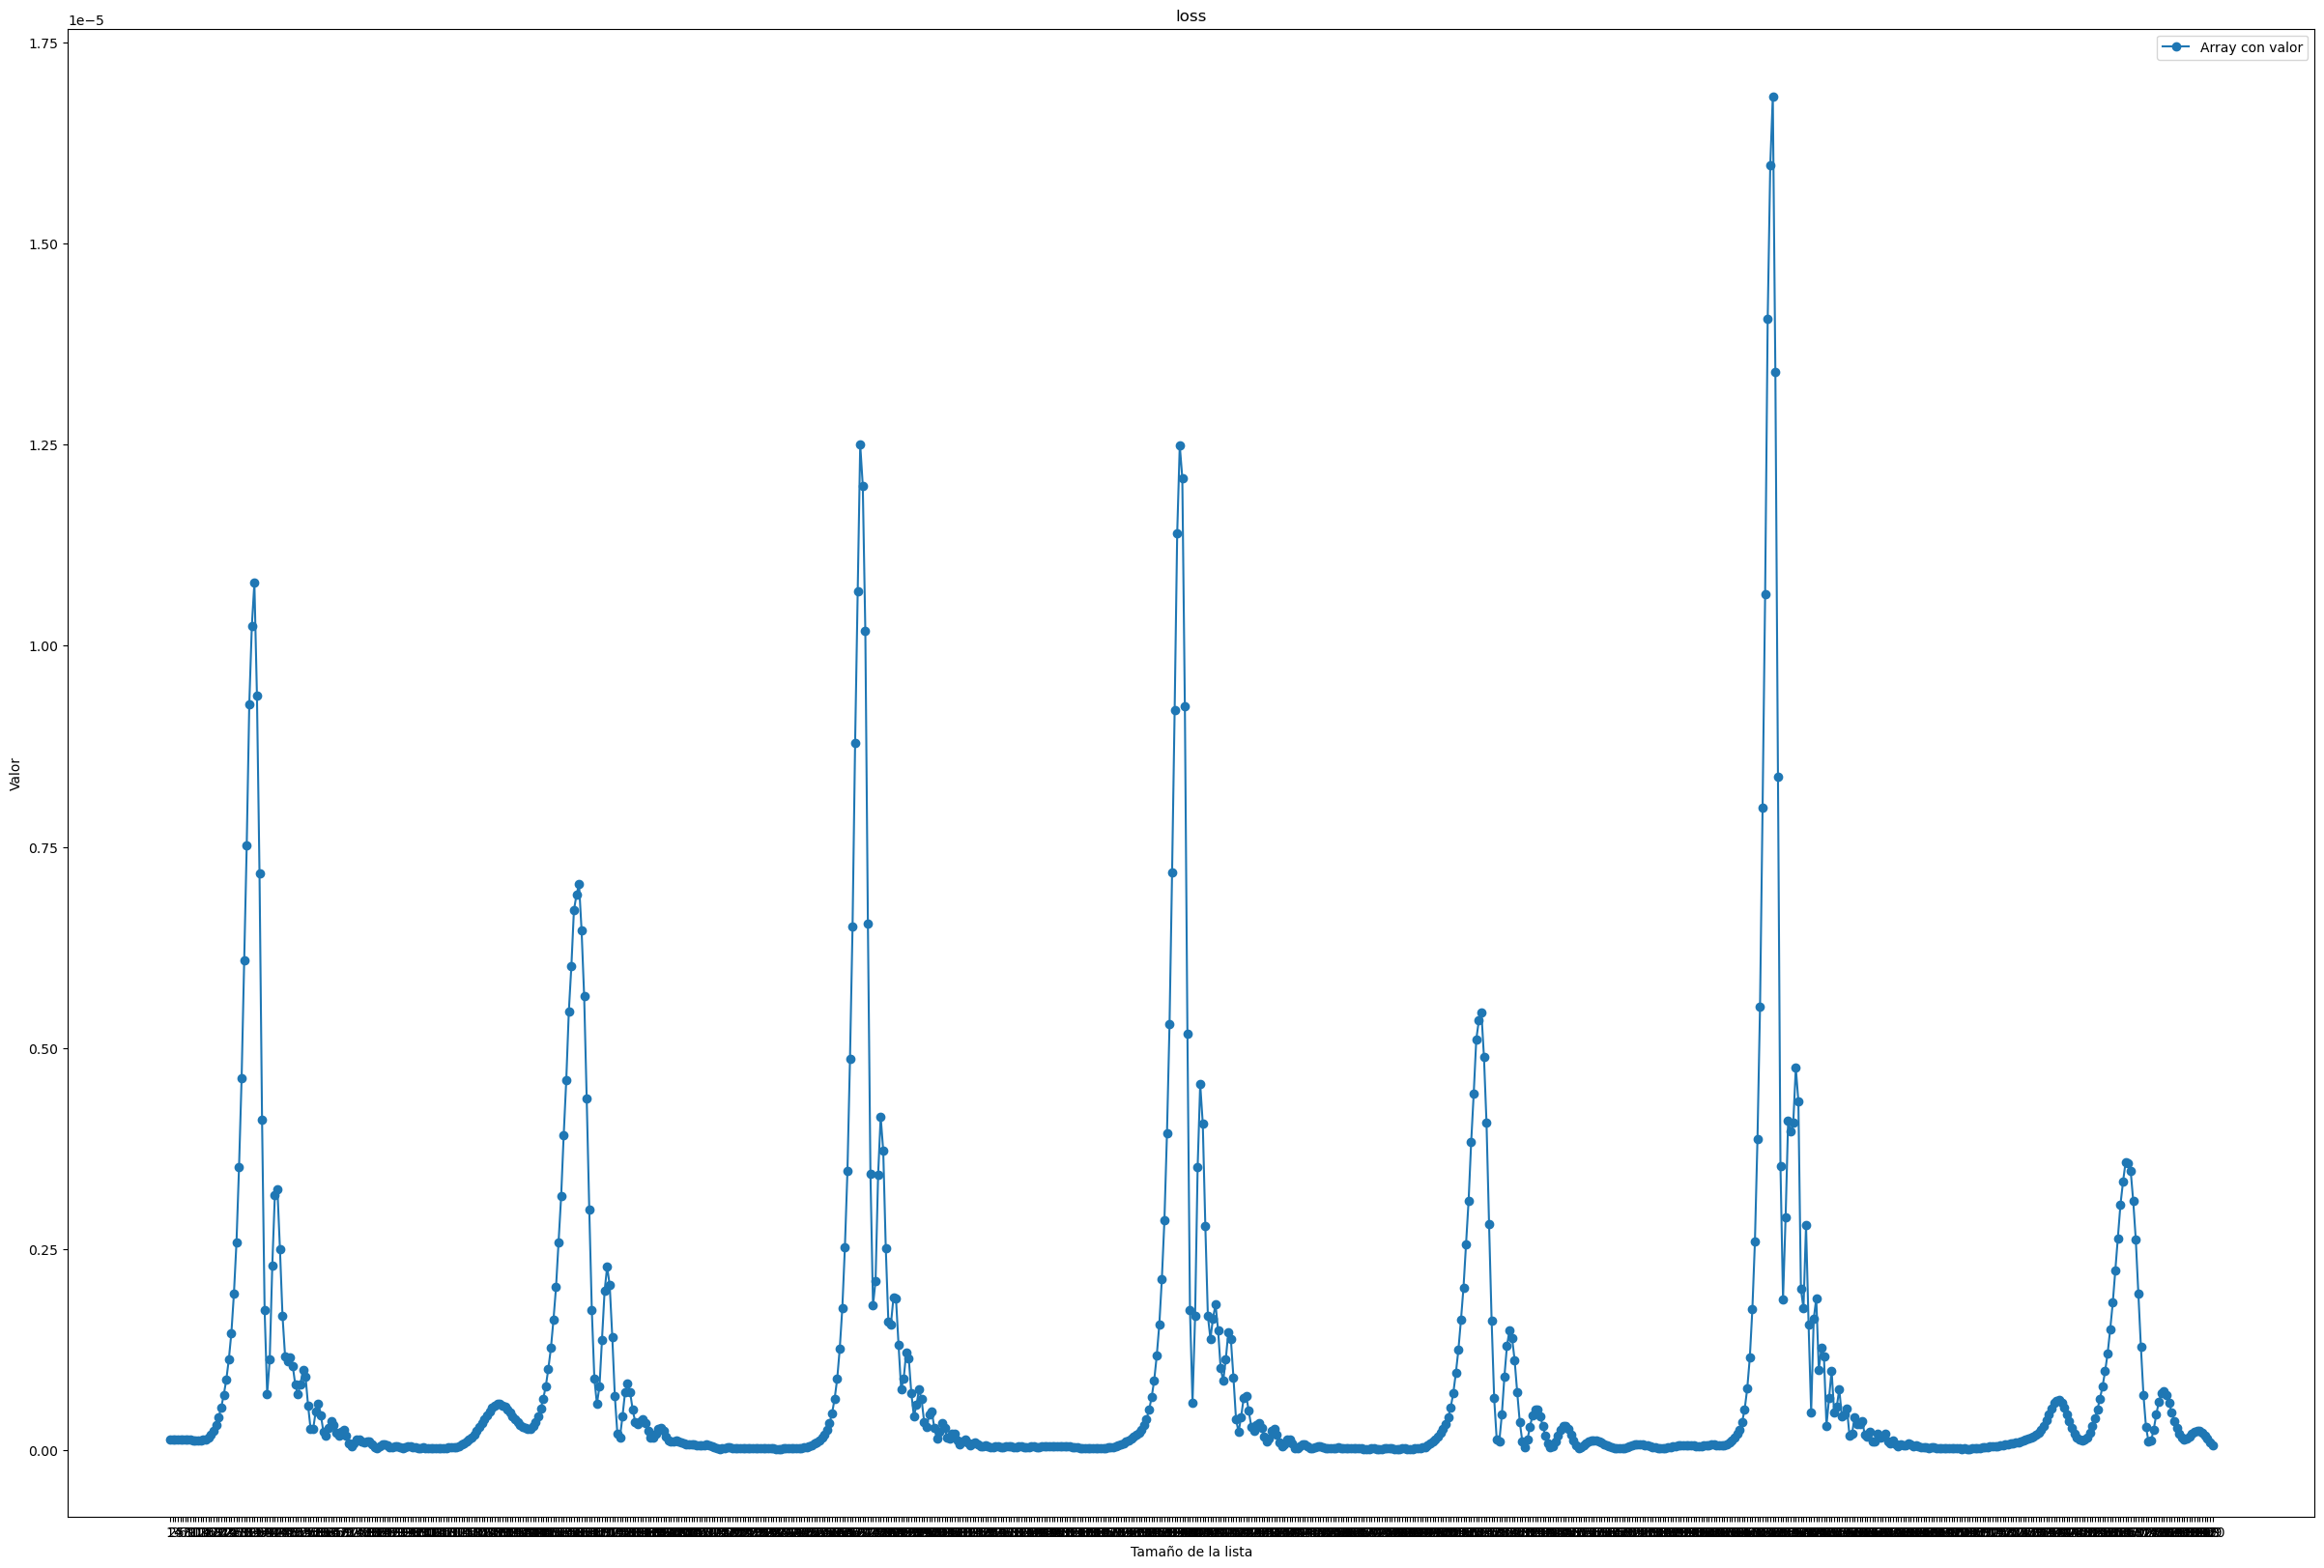

In [30]:
temp_lista_loss = lista_loss[55000:55800]

# Crear una lista de índices para representar el tamaño de la lista
indices = list(range(1, len(temp_lista_loss) + 1))

# Establecer el tamaño de la figura
plt.figure(figsize=(30, 20))  # Ancho: 10 pulgadas, Alto: 6 pulgadas

# Trazar el gráfico
plt.plot(indices, temp_lista_loss, 'o-', label='Array con valor')

# Etiquetas y título
plt.xlabel('Tamaño de la lista')
plt.ylabel('Valor')
plt.title('loss')
plt.legend()
plt.xticks(indices)
plt.show()

In [28]:
lista_loss.index(min(lista_loss))

55480

In [46]:
min(lista_loss)

1.8140909219255263e-08

In [44]:
mean_list = []
max = 1
for epoch in lista_loss:
    temp = lista_loss[::max]
    temp = sum(temp) / len(temp)
    mean_list.append(temp)
    max += 1

mean_list.index(min(mean_list))

0

In [45]:
min(mean_list)

6.240806205970101e-05

In [34]:
temp

0.178178071975708

In [35]:
mean_list

[6.240806205970101e-05,
 6.416644793953775e-05,
 6.602967654292372e-05,
 6.828966997420847e-05,
 6.920805580067428e-05,
 6.970292138637378e-05,
 7.23668941838555e-05,
 7.790518982503894e-05,
 8.031633424622993e-05,
 8.079793695576881e-05,
 8.46467848398338e-05,
 8.648145447072203e-05,
 8.895583987015146e-05,
 9.264046227730138e-05,
 9.460807410409126e-05,
 9.967198304730129e-05,
 0.0001007906324032245,
 0.00010291556757548559,
 0.00010468089705317363,
 0.00010706242506774436,
 0.00010991699962669083,
 0.00011360967718512453,
 0.00011483124254470505,
 0.00011540445225113748,
 0.00011760695577750492,
 0.00012203661790722207,
 0.00012542340843097645,
 0.00012871833697408709,
 0.00013045908513422699,
 0.00013272844634211912,
 0.00013635784207114126,
 0.00014151766117190034,
 0.00014325005707831596,
 0.00014435071487908717,
 0.00014864881807282257,
 0.00015243441747395342,
 0.00015566117910330274,
 0.00016087966078003426,
 0.00016159034994517045,
 0.00016748609299788004,
 0.0001697357388932